# Import libraries and mount drive

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
from pathlib import Path
import re
import requests
from io import StringIO

from matplotlib.legend_handler import HandlerTuple

# Code

In [2]:
desplazamientos = pd.read_csv("../input_data/trips.csv")
desplazamientos

,Unnamed: 0,Prov_Ori,Prov_Des,Com_Ori,Com_Des,Mun_Ori,Mun_Des,Act_Ori,Act_Des,Proposito,...,Motos,Tipo_familia,Sexo,Edad,Actividad,crnt_tur,crnt_mot,crnt_otr,Año,Income
0,0,20,20,Donostialdea,Donostialdea,Donostia/San Sebastian,Donostia/San Sebastian,Otra vivienda,Centro estudios,Otros,...,1,2 adultos con niño(s),2,2,4,2,2,2,2021,8944.175
1,1,20,20,Donostialdea,Donostialdea,Donostia/San Sebastian,Donostia/San Sebastian,Centro estudios,Compras doméstico-familiares,Estudio,...,1,2 adultos con niño(s),2,2,4,2,2,2,2021,8944.175
2,2,20,20,Donostialdea,Donostialdea,Donostia/San Sebastian,Donostia/San Sebastian,Compras doméstico-familiares,Otra vivienda,Compras,...,1,2 adultos con niño(s),2,2,4,2,2,2,2021,10539.365
3,3,20,20,Donostialdea,Goierri,Donostia/San Sebastian,Beasain,Asuntos trabajo,Asuntos trabajo,Trabajo,...,1,2 adultos con niño(s),1,5,1,1,2,1,2021,25397.860
4,4,20,20,Debagoiena,Donostialdea,Arrasate/Mondragon,Donostia/San Sebastian,Asuntos trabajo,Asuntos trabajo,Trabajo,...,1,2 adultos con niño(s),1,5,1,1,2,2,2021,27611.510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21899,21899,20,20,Donostialdea,Donostialdea,Hernani,Hernani,Gestiones personales,Residencia Habitual,Gestiones Personales,...,1,Hogar de una persona,1,6,3,1,2,2,2011,21474.460
21900,21900,20,20,Goierri,Goierri,Zumarraga,Zumarraga,Residencia Habitual,Trabajo habitual,Trabajo,...,1,2 adultos,1,5,1,1,2,2,2011,28070.860
21901,21901,20,20,Goierri,Goierri,Zumarraga,Zumarraga,Trabajo habitual,Residencia Habitual,Trabajo,...,1,2 adultos,1,5,1,1,2,2,2011,25703.710
21902,21902,20,20,Goierri,Goierri,Zumarraga,Zumarraga,Residencia Habitual,Compras personales,Compras,...,1,2 adultos,2,5,6,2,2,2,2011,13577.460


# Study Donosti as the center of Gipuzkoa. Centralized region

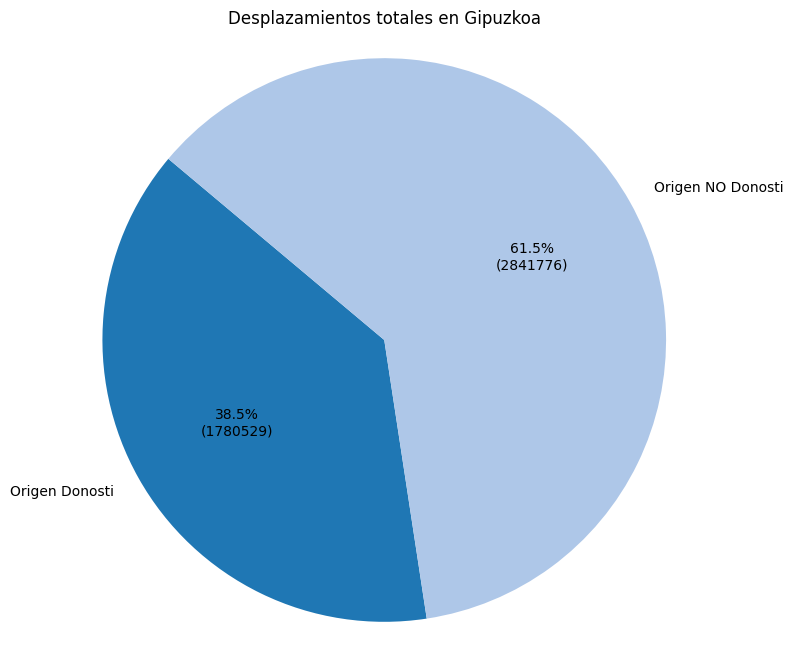

In [3]:
desplazamientos_total = desplazamientos['elev'].sum()
desplazamientos_origen_donosti= desplazamientos.loc[desplazamientos['Mun_Ori'] == 'Donostia/San Sebastian', 'elev'].sum()
valores = [desplazamientos_origen_donosti,desplazamientos_total-desplazamientos_origen_donosti]
etiquetas = ['Origen Donosti', 'Origen NO Donosti']

plt.figure(figsize=(8, 8))
plt.pie(valores, labels=etiquetas, autopct=lambda pct: f"{pct:.1f}%\n({int(pct * sum(valores) / 100)})", startangle=140, colors=plt.cm.tab20.colors)
plt.axis('equal')

plt.title("Desplazamientos totales en Gipuzkoa")
plt.show()

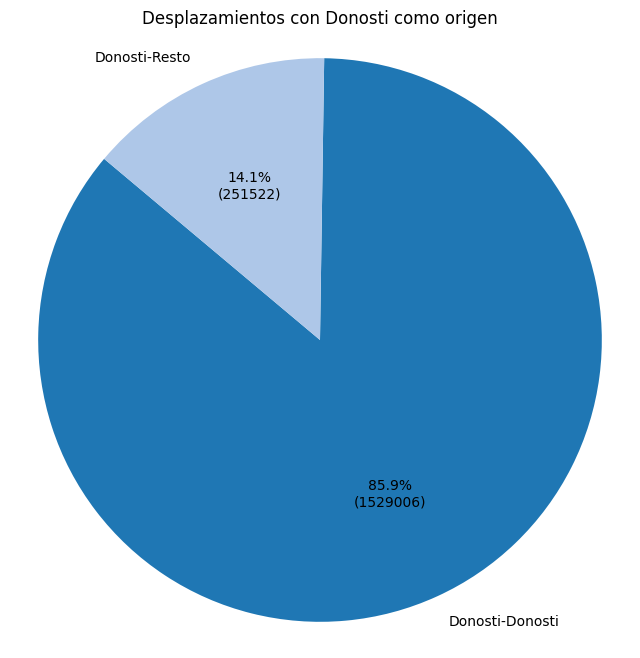

In [4]:
condicion = desplazamientos['Mun_Ori'] == 'Donostia/San Sebastian'
origen_donosti_df=desplazamientos[condicion]

desplazamientos_donosti_donosti=origen_donosti_df.loc[origen_donosti_df['Mun_Des'] == 'Donostia/San Sebastian', 'elev'].sum()

valores = [desplazamientos_donosti_donosti,desplazamientos_origen_donosti-desplazamientos_donosti_donosti]
etiquetas = ['Donosti-Donosti', 'Donosti-Resto']

plt.figure(figsize=(8, 8))
plt.pie(valores, labels=etiquetas, autopct=lambda pct: f"{pct:.1f}%\n({int(pct * sum(valores) / 100)})", startangle=140, colors=plt.cm.tab20.colors)
plt.axis('equal')

plt.title("Desplazamientos con Donosti como origen")
plt.show()

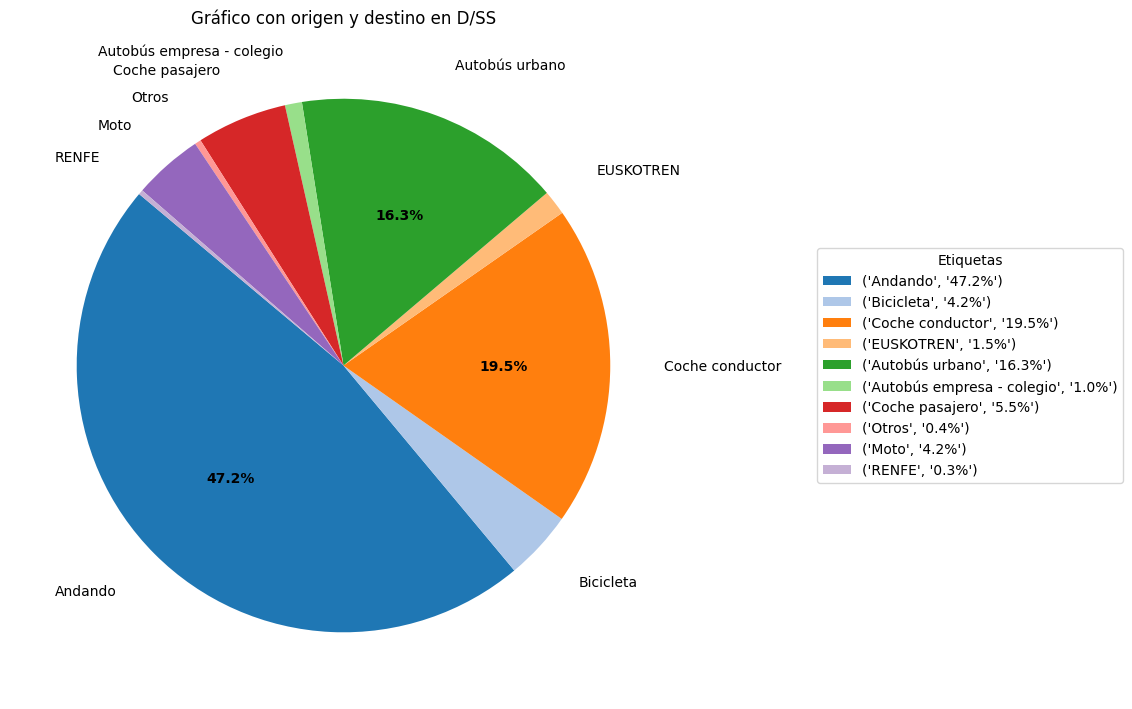

In [5]:
# Origin and destination in Donosti

condicion2 = origen_donosti_df['Mun_Des'] == 'Donostia/San Sebastian'
origen_D_desitno_D = origen_donosti_df[condicion2]

DD = origen_D_desitno_D.groupby(['Modo'])['elev'].sum()
DD_df = pd.DataFrame(DD).reset_index()

# Order df not to superimpose the names. First the biggest number, then the smallest, then second biggest, etc. (MADE UP)

DD_df = DD_df.sort_values(by='elev', ascending=False)
half_len = len(DD_df) // 2
DD_df = pd.concat([DD_df.iloc[:half_len], DD_df.iloc[half_len:]])

result = []
for i in range(half_len):
    result.append(DD_df.iloc[i])
    result.append(DD_df.iloc[i + half_len])

DD_df = pd.DataFrame(result, columns=DD_df.columns)

# Graph

fig, ax = plt.subplots(figsize=(8, 8))
DD_df['porcentaje'] = (DD_df['elev'] / DD_df['elev'].sum()) * 100

def autopct_func(pct):
    total = sum(DD_df['elev'])
    valor = int(round(pct * total / 100.0))
    if pct >= 10:
        return f'{pct:.1f}%\n({valor:d})'
    else:
        return ''

wedges, texts, autotexts = ax.pie(DD_df['elev'], labels=DD_df['Modo'], autopct=lambda pct: f"{pct:.1f}%" if pct > 10 else '', startangle=140, colors=plt.cm.tab20.colors, labeldistance = 1.2)
plt.setp(autotexts, size=10, weight="bold")  # Tamaño y estilo del texto con los porcentajes

# Adjust label position
plt.tight_layout()

# Create personalized label table
handlers = [HandlerTuple(ndivide=None)]
legend_labels = [(label, f"{porcentaje:.1f}%") for label, porcentaje in zip(DD_df['Modo'], DD_df['porcentaje'])]
ax.legend(wedges, legend_labels, title="Etiquetas", handler_map={tuple: HandlerTuple(ndivide=None)}, loc="center left", bbox_to_anchor=(1.2, 0, 0.5, 1))

plt.title("Gráfico con origen y destino en D/SS")

plt.show()

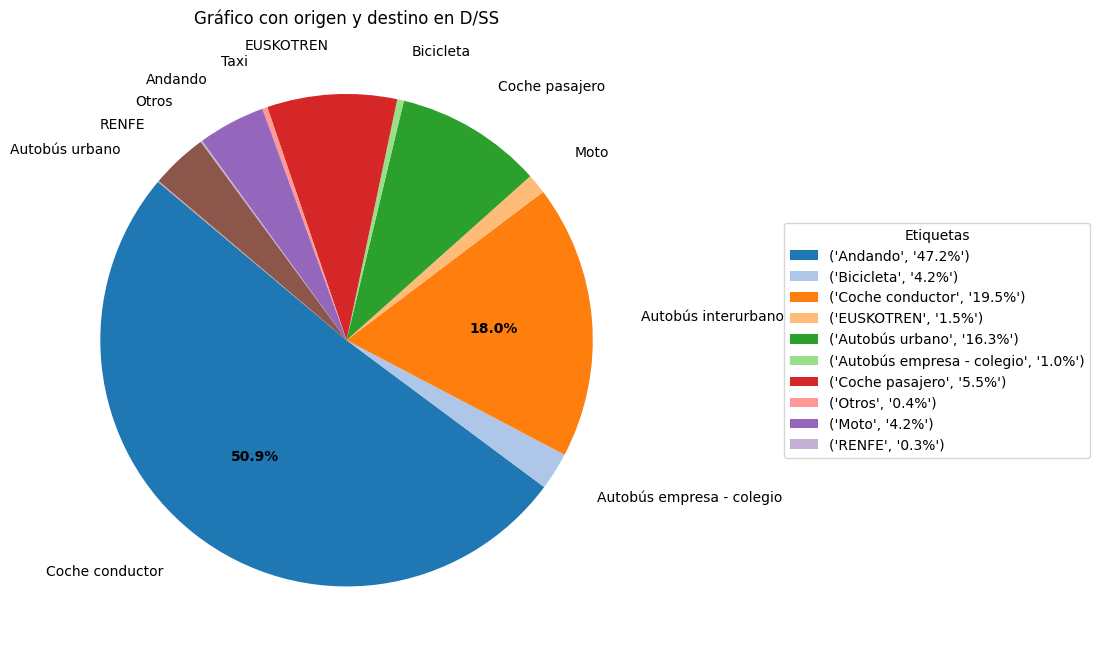

In [6]:
# Origin and destination out of Donosti
condicion2 = origen_donosti_df['Mun_Des'] != 'Donostia/San Sebastian'
origen_D_desitno_E = origen_donosti_df[condicion2]

DE = origen_D_desitno_E.groupby(['Modo'])['elev'].sum()
DE_df = pd.DataFrame(DE).reset_index()

DE_df = DE_df.sort_values(by='elev', ascending=False)
half_len = len(DE_df) // 2
DE_df = pd.concat([DE_df.iloc[:half_len], DE_df.iloc[half_len:]])

result = []
for i in range(half_len):
    result.append(DE_df.iloc[i])
    result.append(DE_df.iloc[i + half_len])

DE_df = pd.DataFrame(result, columns=DE_df.columns)

# Graph

fig, ax = plt.subplots(figsize=(8, 8))
DE_df['porcentaje'] = (DE_df['elev'] / DE_df['elev'].sum()) * 100

def autopct_func(pct):
    total = sum(DE_df['elev'])
    valor = int(round(pct * total / 100.0))
    if pct >= 10:
        return f'{pct:.1f}%\n({valor:d})'
    else:
        return ''

wedges, texts, autotexts = ax.pie(DE_df['elev'], labels=DE_df['Modo'], autopct=lambda pct: f"{pct:.1f}%" if pct > 10 else '', startangle=140, colors=plt.cm.tab20.colors, labeldistance = 1.2)
plt.setp(autotexts, size=10, weight="bold")  # Tamaño y estilo del texto con los porcentajes

plt.tight_layout()

handlers = [HandlerTuple(ndivide=None)]
legend_labels = [(label, f"{porcentaje:.1f}%") for label, porcentaje in zip(DD_df['Modo'], DD_df['porcentaje'])]
ax.legend(wedges, legend_labels, title="Etiquetas", handler_map={tuple: HandlerTuple(ndivide=None)}, loc="center left", bbox_to_anchor=(1.2, 0, 0.5, 1))

plt.title("Gráfico con origen y destino en D/SS")

plt.show()

## Analysis to confirm Zuriñe's data for Summit presentation

In [7]:
trips = desplazamientos

In [8]:
# Expand trips

nuevas_filas = []
for index, row in trips.iterrows():
    valores_columnas = row[trips.columns]
    repeticiones = row['elev']
    nuevas_filas.extend([valores_columnas] * repeticiones)

trips = pd.DataFrame(nuevas_filas, columns=trips.columns)

trips = trips.drop(columns=["elev"])

# Randomly mix rows
trips = trips.sample(frac=1).reset_index(drop=True)
trips

,Unnamed: 0,Prov_Ori,Prov_Des,Com_Ori,Com_Des,Mun_Ori,Mun_Des,Act_Ori,Act_Des,Proposito,...,Motos,Tipo_familia,Sexo,Edad,Actividad,crnt_tur,crnt_mot,crnt_otr,Año,Income
0,15748,20,20,Donostialdea,Donostialdea,Errenteria,Donostia/San Sebastian,Residencia Habitual,Asuntos trabajo,Trabajo,...,1,Otros hogares sin niños,1,3,1,1,2,2,2011,20129.345
1,12953,20,20,Donostialdea,Donostialdea,Donostia/San Sebastian,Donostia/San Sebastian,Compras doméstico-familiares,"Ocio, cultura, deporte",Ocio,...,1,Hogar de una persona,2,6,3,2,2,2,2016,18389.120
2,7531,20,20,Tolosaldea,Donostialdea,Tolosa,Andoain,Trabajo habitual,Residencia Habitual,Trabajo,...,1,Otros hogares con niños,1,4,1,1,2,2,2016,22025.720
3,4415,20,20,Donostialdea,Donostialdea,Donostia/San Sebastian,Donostia/San Sebastian,Residencia Habitual,Otras actividades,Otros,...,1,Hogar de una persona,2,7,3,2,2,2,2021,16680.750
4,18245,20,20,Donostialdea,Donostialdea,Oiartzun,Donostia/San Sebastian,Trabajo habitual,Residencia Habitual,Trabajo,...,1,2 adultos con niño(s),2,4,1,1,2,2,2011,25831.660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4622302,1898,20,20,Bidasoa,Bidasoa,Irun,Irun,Residencia Habitual,"Acompañamiento de ayuda, cuidado",Gestiones Personales,...,1,Otros hogares sin niños,1,5,5,2,2,2,2021,18773.210
4622303,443,20,20,Donostialdea,Donostialdea,Donostia/San Sebastian,Donostia/San Sebastian,"Ocio, cultura, deporte",Otra vivienda,Ocio,...,1,2 adultos,1,7,3,1,2,2,2021,17806.700
4622304,12533,20,20,Donostialdea,Donostialdea,Donostia/San Sebastian,Donostia/San Sebastian,Médico / Hospital,Residencia Habitual,Gestiones Personales,...,1,1 adulto con niño(s),1,3,4,1,2,2,2016,8605.125
4622305,3518,20,20,Donostialdea,Donostialdea,Errenteria,Errenteria,"Ocio, cultura, deporte",Residencia Habitual,Ocio,...,1,Hogar de una persona,1,7,3,1,2,2,2021,18924.620


In [9]:
trips.loc[trips.Modo=="Coche pasajero","Modo"] = "Coche"
trips.loc[trips.Modo=="Coche conductor","Modo"] = "Coche"
trips.loc[trips.Modo=="Moto","Modo"] = "Coche"
trips.loc[trips.Modo=="Taxi","Modo"] = "Coche"
trips.loc[trips.Modo=="Autobús interurbano","Modo"] = "TP"
trips.loc[trips.Modo=="Autobús urbano","Modo"] = "TP"
trips.loc[trips.Modo=="Autobús empresa - colegio","Modo"] = "TP"
trips.loc[trips.Modo=="EUSKOTREN","Modo"] = "TP"
trips.loc[trips.Modo=="RENFE","Modo"] = "TP"

trips = trips[trips['Modo'] != 'Multimodal']
trips = trips[trips['Modo'] != 'Otros']

In [11]:
desplazamientos =  trips

In [12]:
desplazamientos['Tipo'] = desplazamientos.apply(lambda row: "Intramunicipal" if row['Mun_Ori'] == row['Mun_Des'] else "Intermunicipal", axis=1)

desplazamientos = desplazamientos.groupby(['Modo', 'Tipo']).size().reset_index(name='Cantidad')

suma_total = desplazamientos['Cantidad'].sum()

desplazamientos['Porcentaje'] = (desplazamientos['Cantidad'] / suma_total) * 100

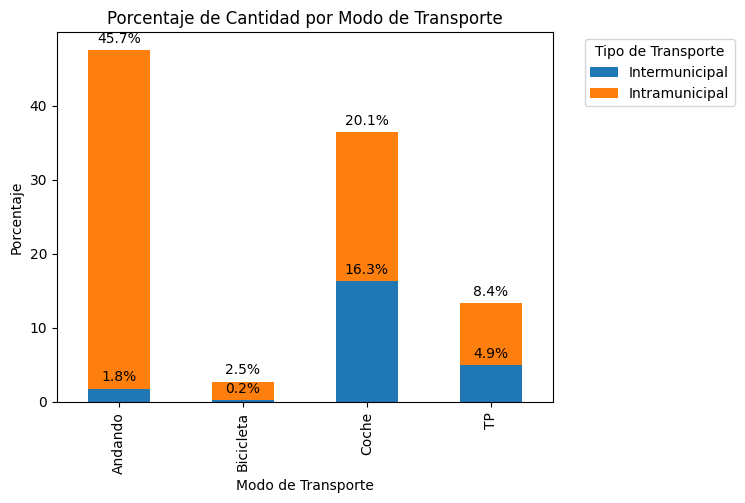

In [13]:
# Bar graph
fig, ax = plt.subplots()

# Group by mode and type of transportation
grupo = desplazamientos.groupby(['Modo', 'Tipo'])['Porcentaje'].sum().unstack()

grafico = grupo.plot(kind='bar', stacked=True, ax=ax)

# Personalize graph
plt.xlabel('Modo de Transporte')
plt.ylabel('Porcentaje')
plt.title('Porcentaje de Cantidad por Modo de Transporte')
plt.legend(title='Tipo de Transporte')

for p in grafico.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height + 1), ha='center')

ax.legend(title='Tipo de Transporte', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()